# Cross checks

Johann Brehmer, Kyle Cranmer, Marco Farina, Felix Kling, Duccio Pappadopulo, Josh Ruderman 2018

In [20]:
from __future__ import absolute_import, division, print_function, unicode_literals

import math
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.core import MadMiner
from madminer.delphes import DelphesProcessor
from madminer.sampling import SampleAugmenter
from madminer.utils.particle import MadMinerParticle
from madminer.sampling import multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas

In [21]:
base_dir = '/Users/johannbrehmer/work/projects/madminer/diboson_mining/'
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2/'

In [22]:
sample_dir = base_dir + 'data/samples/wgamma_check/'
card_dir = base_dir + 'cards/wgamma_check/'
ufo_model_dir = card_dir + 'SMWgamma_UFO'
run_card_dir = card_dir + 'run_cards/'
mg_process_dir = base_dir + 'data/mg_processes/wgamma_check/'
mg_process_dir2 = base_dir + 'data/mg_processes/wgamma_check2/'
log_dir = base_dir + 'logs/wgamma_check/'
temp_dir = base_dir + 'data/temp'
delphes_dir = mg_dir + 'Delphes'

## Load setup

In [4]:
mm = MadMiner(debug=False)

mm.load(sample_dir + 'setup.h5')

11:10  
11:10  ------------------------------------------------------------
11:10  |                                                          |
11:10  |  MadMiner v0.1.0                                         |
11:10  |                                                          |
11:10  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
11:10  |                                                          |
11:10  ------------------------------------------------------------
11:10  
11:10  Found 2 parameters:
11:10     cWWW (LHA: dim6 1, maximal power in squared ME: (2,), range: (-0.02, 0.02))
11:10     cWWWtilde (LHA: dim6 2, maximal power in squared ME: (2,), range: (-0.02, 0.02))
11:10  Found 6 benchmarks:
11:10     sm: cWWW = 0.00e+00, cWWWtilde = 0.00e+00
11:10     morphing_basis_vector_1: cWWW = -6.07e-03, cWWWtilde = -1.84e-02
11:10     morphing_basis_vector_2: cWWW = 1.00e-02, cWWWtilde = 1.70e-02
11:10     morphing_basis_vector_3: cWWW = -1.99e-02, cWWWtilde = 1.87e-02
11:

## Run MG

In [5]:
mm.run(
    mg_directory=mg_dir,
    proc_card_file=card_dir + 'proc_card_mg5.dat',
    param_card_template_file=card_dir + 'param_card.dat',
    pythia8_card_file=card_dir + 'pythia8_card.dat',
    run_card_file=card_dir + 'run_card_tight.dat',
    mg_process_directory=mg_process_dir,
    ufo_model_directory=ufo_model_dir,
    temp_directory=temp_dir,
    sample_benchmark='sm',
    is_background=False,
    only_prepare_script=False,
    initial_command='source activate python2',
    log_directory=log_dir
)

11:11  Generating MadGraph process folder from /Users/johannbrehmer/work/projects/madminer/diboson_mining/cards/wgamma_check/proc_card_mg5.dat at /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/mg_processes/wgamma_check/
11:11  Run 0
11:11    Sampling from benchmark: sm
11:11    Original run card:       /Users/johannbrehmer/work/projects/madminer/diboson_mining/cards/wgamma_check/run_cards/run_card.dat
11:11    Original Pythia8 card:   /Users/johannbrehmer/work/projects/madminer/diboson_mining/cards/wgamma_check/pythia8_card.dat
11:11    Copied run card:         /madminer/cards/run_card_0.dat
11:11    Copied Pythia8 card:     /madminer/cards/pythia8_card_0.dat
11:11    Param card:              /madminer/cards/param_card_0.dat
11:11    Reweight card:           /madminer/cards/reweight_card_0.dat
11:11    Log file:                run_0.log
11:11  Creating param and reweight cards in /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/mg_processes/wgamma_check/

In [23]:
mm.run(
    mg_directory=mg_dir,
    proc_card_file=card_dir + 'proc_card_mg5.dat',
    param_card_template_file=card_dir + 'param_card.dat',
    pythia8_card_file=card_dir + 'pythia8_card.dat',
    run_card_file=card_dir + 'run_card_loose.dat',
    mg_process_directory=mg_process_dir2,
    ufo_model_directory=ufo_model_dir,
    temp_directory=temp_dir,
    sample_benchmark='sm',
    is_background=False,
    only_prepare_script=False,
    initial_command='source activate python2',
    log_directory=log_dir
)

13:21  Generating MadGraph process folder from /Users/johannbrehmer/work/projects/madminer/diboson_mining/cards/wgamma_check/proc_card_mg5.dat at /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/mg_processes/wgamma_check2/
13:21  Run 0
13:21    Sampling from benchmark: sm
13:21    Original run card:       /Users/johannbrehmer/work/projects/madminer/diboson_mining/cards/wgamma_check/run_card_loose.dat
13:21    Original Pythia8 card:   /Users/johannbrehmer/work/projects/madminer/diboson_mining/cards/wgamma_check/pythia8_card.dat
13:21    Copied run card:         /madminer/cards/run_card_0.dat
13:21    Copied Pythia8 card:     /madminer/cards/pythia8_card_0.dat
13:21    Param card:              /madminer/cards/param_card_0.dat
13:21    Reweight card:           /madminer/cards/reweight_card_0.dat
13:21    Log file:                run_0.log
13:21  Creating param and reweight cards in /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/mg_processes/wgamma_check2///

## Define observables

In [6]:
def calculate_mt(leptons, photons, jets, met):
    # Particles
    if len(leptons) < 1:
        raise RuntimeError()
    
    l = leptons[0]
    
    # Transverse mass and Delta
    cos_delta_phi = np.cos(l.phi() - met.phi())
    mt = (2 * l.pt * met.pt * (1. - cos_delta_phi))**0.5
    
    return mt

In [27]:
def calculate_phi(leptons, photons, jets, met):
    # Parameters
    mw = 80.4
    
    # Particles
    if len(leptons) < 1 or len(photons) < 1:
        raise RuntimeError()
    
    l = leptons[0]
    a = photons[0]
    
    # Transverse mass and Delta
    mt = calculate_mt(leptons, photons, jets, met)
    deltasq = 0.
    if met.pt > 0. and l.pt > 0.:
        deltasq = (mw**2 - mt**2) / (2. * met.pt * l.pt)
    
    # v reconstruction, "normal" case
    if deltasq > 0.:
        # Two solutions
        temp = np.log(1 + deltasq**0.5 * (2 + deltasq)**0.5 + deltasq)
        eta_v_plus = l.eta + temp
        eta_v_minus = l.eta - temp
        
        # Randomly select one of them
        dice = np.random.rand()
        if dice > 0.5:
            eta_v = eta_v_plus
        else:
            eta_v = eta_v_minus
            
    # v reconstruction, "other" case
    else:
        eta_v = l.eta
        
    # v particle
    v = MadMinerParticle()
    v.setptetaphim(met.pt, eta_v, met.phi(), 0.)
    
    # W and Wgamma reconstruction
    w = l + v
    vv = w + a
    
    # Boost into VV frame
    v_ = v.boost(vv.boostvector)
    l_ = l.boost(vv.boostvector)
    a_ = a.boost(vv.boostvector)
    w_ = w.boost(vv.boostvector)
    r_ = vv # vv.boost(vv.boostvector)

    # Calculate axes of "special frame" (1708.07823)
    z_ = w_.vector.unit()
    x_ = (r_.vector - z_ * r_.vector.dot(z_)).unit()
    y_ = z_.cross(x_)
    
    # Calculate x and y components of lepton wrt special x_, y_, z_ system
    lx_ = l_.vector.dot(x_)
    ly_ = l_.vector.dot(y_)
    
    # Calculate phi
    phi = math.atan2(ly_, lx_)
    
    return phi
    

In [28]:
def setup_observables(delphesprocessor):
    delphesprocessor.reset_observables()
        
    # Default observables
    delphesprocessor.add_default_observables(
        n_leptons_max=1,
        n_photons_max=1,
        n_jets_max=0,
        include_charge=False,
        include_numbers=False,
        include_met=True
    )
    
    # Lepton flavour
    delphesprocessor.add_observable(
        'pdgid_l1',
        'l[0].pdgid',
        required=True
    )

    # Correlations with MET
    for s1, i1 in [('l', 0), ('a', 0)]:
        delphesprocessor.add_observable(
            'deltaphi_{}{}_met'.format(s1, i1+1),
            '{}[{}].phi() - met.phi()'.format(s1, i1),
            required=True
        )

    # Reconstructed W
    delphesprocessor.add_observable(
        'm_l1_met',
        '(l[0] + met).m',
        required=True
    )
    delphesprocessor.add_observable(
        'pt_l1_met',
        '(l[0] + met).pt',
        required=True
    )

    # Selected correlations between particles
    for s1, i1, s2, i2 in [('l', 0, 'a', 0)]:
        delphesprocessor.add_observable(
            'm_{}{}_{}{}'.format(s1, i1+1, s2, i2+1),
            '({}[{}] + {}[{}]).m'.format(s1, i1, s2, i2),
            required=True
        )
        delphesprocessor.add_observable(
            'deltaeta_{}{}_{}{}'.format(s1, i1+1, s2, i2+1),
            '{}[{}].eta - {}[{}].eta'.format(s1, i1, s2, i2),
            required=True
        )
        delphesprocessor.add_observable(
            'deltaphi_{}{}_{}{}'.format(s1, i1+1, s2, i2+1),
            '{}[{}].phi() - {}[{}].phi()'.format(s1, i1, s2, i2),
            required=True
        )

    # Wgamma system
    delphesprocessor.add_observable(
        'm_a1_l1_met',
        '(a[0] + l[0] + met).m',
        required=True
    )
    delphesprocessor.add_observable(
        'pt_a1_l1_met',
        '(a[0] + l[0] + met).pt',
        required=True
    )
    
    # mT(W)
    delphesprocessor.add_observable_from_function(
        'mt',
        calculate_mt,
        required=True
    )
    
    # Resurection phi
    delphesprocessor.add_observable_from_function(
        'phi_resurrection',
        calculate_phi,
        required=True
    )


In [29]:
def setup_cuts(delphesprocessor):
    delphesprocessor.reset_cuts()
    
    delphesprocessor.add_cut(
        'pt_a1 >= 300.'
    )
    delphesprocessor.add_cut(
        'pt_l1 >= 80.'
    )
    delphesprocessor.add_cut(
        'et_miss >= 80.'
    )
    delphesprocessor.add_cut(
        '(deltaphi_l1_a1**2 + deltaeta_l1_a1**2)**0.5 >= 3.'
    )
    delphesprocessor.add_cut(
        'eta_l1**2 < 2.4**2'
    )
        

## Run Delphes

In [30]:
# Load setup and events
dp = DelphesProcessor(sample_dir + 'setup.h5', debug=True)
dp.add_hepmc_sample(
    mg_process_dir + 'Events/run_01/tag_1_pythia8_events.hepmc.gz',
    sampled_from_benchmark='sm'
)

# Run Delphes (CMS)
dp.run_delphes(
    delphes_directory=delphes_dir,
    delphes_card=card_dir + 'delphes_card_mg5_CMS.dat',
    log_file=log_dir + '/delphes.log',
    initial_command='source activate python2',
)

# Analysis (generator truth)
setup_observables(dp)
setup_cuts(dp)

dp.analyse_delphes_samples(generator_truth=True, delete_delphes_files=False)
dp.save(sample_dir + 'samples_truth.h5')

# Analysis (CMS)
dp.analyse_delphes_samples(delete_delphes_files=False)
dp.save(sample_dir + 'samples_cms.h5')


13:56  Benchmarks found in MadMiner file: ['sm', 'morphing_basis_vector_1', 'morphing_basis_vector_2', 'morphing_basis_vector_3', 'morphing_basis_vector_4', 'morphing_basis_vector_5']
13:56  Adding HepMC sample at /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/mg_processes/wgamma_check/Events/run_01/tag_1_pythia8_events.hepmc.gz
13:56  Calling gunzip -k /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/mg_processes/wgamma_check/Events/run_01/tag_1_pythia8_events.hepmc.gz > None
13:56  Found weight labels in HEPMC file: ['sm', 'morphing_basis_vector_1', 'morphing_basis_vector_2', 'morphing_basis_vector_3', 'morphing_basis_vector_4', 'morphing_basis_vector_5']
13:56  Running Delphes (/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2/Delphes) on event sample at /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/mg_processes/wgamma_check/Events/run_01/tag_1_pythia8_events.hepmc.gz
13:56  Unzipping /Users/johannbrehmer/work/projects/madmi

14:11    100000 / 100000 events pass required observable eta_visible
14:11    95877 / 100000 events pass required observable pdgid_l1
14:11    95877 / 100000 events pass required observable deltaphi_l1_met
14:11    93525 / 100000 events pass required observable deltaphi_a1_met
14:11    95877 / 100000 events pass required observable m_l1_met
14:11    95877 / 100000 events pass required observable pt_l1_met
14:11    89486 / 100000 events pass required observable m_l1_a1
14:11    89486 / 100000 events pass required observable deltaeta_l1_a1
14:11    89486 / 100000 events pass required observable deltaphi_l1_a1
14:11    89486 / 100000 events pass required observable m_a1_l1_met
14:11    89486 / 100000 events pass required observable pt_a1_l1_met
14:11    95877 / 100000 events pass required observable mt
14:11    89486 / 100000 events pass required observable phi_resurrection
14:11    21385 / 100000 events pass cut pt_a1 >= 300.
14:11    88799 / 100000 events pass cut pt_l1 >= 80.
14:11    

In [31]:
# Load setup and events
dp = DelphesProcessor(sample_dir + 'setup.h5', debug=True)
dp.add_hepmc_sample(
    mg_process_dir + 'Events/run_01/tag_1_pythia8_events.hepmc.gz',
    sampled_from_benchmark='sm'
)

# Run Delphes (ATLAS)
dp.run_delphes(
    delphes_directory=delphes_dir,
    delphes_card=card_dir + 'delphes_card_mg5_ATLAS.dat',
    log_file=log_dir + '/delphes_ATLAS.log',
    initial_command='source activate python2',
)

# Analysis (ATLAS)
setup_observables(dp)
setup_cuts(dp)

dp.analyse_delphes_samples(delete_delphes_files=False)
dp.save(sample_dir + 'samples_atlas.h5')



14:14  Benchmarks found in MadMiner file: ['sm', 'morphing_basis_vector_1', 'morphing_basis_vector_2', 'morphing_basis_vector_3', 'morphing_basis_vector_4', 'morphing_basis_vector_5']
14:14  Adding HepMC sample at /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/mg_processes/wgamma_check/Events/run_01/tag_1_pythia8_events.hepmc.gz
14:14  Calling gunzip -k /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/mg_processes/wgamma_check/Events/run_01/tag_1_pythia8_events.hepmc.gz > None
14:14  Found weight labels in HEPMC file: ['sm', 'morphing_basis_vector_1', 'morphing_basis_vector_2', 'morphing_basis_vector_3', 'morphing_basis_vector_4', 'morphing_basis_vector_5']
14:14  Running Delphes (/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2/Delphes) on event sample at /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/mg_processes/wgamma_check/Events/run_01/tag_1_pythia8_events.hepmc.gz
14:14  Unzipping /Users/johannbrehmer/work/projects/madmi

14:19    100000 / 100000 events pass required observable eta_visible
14:19    78468 / 100000 events pass required observable pdgid_l1
14:19    78468 / 100000 events pass required observable deltaphi_l1_met
14:19    82789 / 100000 events pass required observable deltaphi_a1_met
14:19    78468 / 100000 events pass required observable m_l1_met
14:19    78468 / 100000 events pass required observable pt_l1_met
14:19    63322 / 100000 events pass required observable m_l1_a1
14:19    63322 / 100000 events pass required observable deltaeta_l1_a1
14:19    63322 / 100000 events pass required observable deltaphi_l1_a1
14:19    63322 / 100000 events pass required observable m_a1_l1_met
14:19    63322 / 100000 events pass required observable pt_a1_l1_met
14:19    78468 / 100000 events pass required observable mt
14:19    63322 / 100000 events pass required observable phi_resurrection
14:19    20832 / 100000 events pass cut pt_a1 >= 300.
14:19    73259 / 100000 events pass cut pt_l1 >= 80.
14:19    

In [24]:
# Load setup and events
dp = DelphesProcessor(sample_dir + 'setup.h5', debug=True)
dp.add_hepmc_sample(
    mg_process_dir2 + 'Events/run_01/tag_1_pythia8_events.hepmc.gz',
    sampled_from_benchmark='sm'
)

# Run Delphes (ATLAS)
dp.run_delphes(
    delphes_directory=delphes_dir,
    delphes_card=card_dir + 'delphes_card_mg5_ATLAS.dat',
    log_file=log_dir + '/delphes_ATLAS.log',
    initial_command='source activate python2',
)

# Analysis (ATLAS)
setup_observables(dp)
setup_cuts(dp)

dp.analyse_delphes_samples(delete_delphes_files=False)
dp.save(sample_dir + 'samples_atlas2.h5')


13:49  Benchmarks found in MadMiner file: ['sm', 'morphing_basis_vector_1', 'morphing_basis_vector_2', 'morphing_basis_vector_3', 'morphing_basis_vector_4', 'morphing_basis_vector_5']
13:49  Adding HepMC sample at /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/mg_processes/wgamma_check2/Events/run_01/tag_1_pythia8_events.hepmc.gz
13:49  Calling gunzip -k /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/mg_processes/wgamma_check2/Events/run_01/tag_1_pythia8_events.hepmc.gz > None
13:49  Found weight labels in HEPMC file: ['sm', 'morphing_basis_vector_1', 'morphing_basis_vector_2', 'morphing_basis_vector_3', 'morphing_basis_vector_4', 'morphing_basis_vector_5']
13:49  Running Delphes (/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2/Delphes) on event sample at /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/mg_processes/wgamma_check2/Events/run_01/tag_1_pythia8_events.hepmc.gz
13:49  Unzipping /Users/johannbrehmer/work/projects/ma

13:53    First 10 values for observable pt_a1_l1_met:
[        nan         nan         nan  7.51544074         nan         nan
 12.9333106          nan  2.30913094         nan]
13:53    First 10 values for observable mt:
[ 0.20035891         nan         nan 72.01628823         nan         nan
 38.65938897         nan 72.58526707         nan]
13:53    First 10 values for observable phi_resurrection:
[        nan         nan         nan -2.3192274          nan         nan
  2.01204281         nan  1.56458389         nan]
13:53    100000 / 100000 events pass required observable et_miss
13:53    100000 / 100000 events pass required observable phi_miss
13:53    100000 / 100000 events pass required observable e_visible
13:53    100000 / 100000 events pass required observable eta_visible
13:53    70380 / 100000 events pass required observable deltaphi_l1_met
13:53    76335 / 100000 events pass required observable deltaphi_a1_met
13:53    70380 / 100000 events pass required observable m_l1_met

## Extract samples

In [32]:
sa = SampleAugmenter(sample_dir + 'samples_truth.h5', debug=False)
x_pythia, weights_pythia = sa.extract_raw_data(theta=[0.,0.])

14:19  Loading data from /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/samples/wgamma_check/samples_truth.h5
14:19  Found 2 parameters:
14:19     cWWW (LHA: dim6 1, maximal power in squared ME: (2,), range: (-0.02, 0.02))
14:19     cWWWtilde (LHA: dim6 2, maximal power in squared ME: (2,), range: (-0.02, 0.02))
14:19  Found 6 benchmarks:
14:19     sm: cWWW = 0.00e+00, cWWWtilde = 0.00e+00
14:19     morphing_basis_vector_1: cWWW = -6.07e-03, cWWWtilde = -1.84e-02
14:19     morphing_basis_vector_2: cWWW = 1.00e-02, cWWWtilde = 1.70e-02
14:19     morphing_basis_vector_3: cWWW = -1.99e-02, cWWWtilde = 1.87e-02
14:19     morphing_basis_vector_4: cWWW = 1.97e-02, cWWWtilde = -1.53e-02
14:19     morphing_basis_vector_5: cWWW = -1.65e-02, cWWWtilde = -6.33e-03
14:19  Found 24 observables: et_miss, phi_miss, e_visible, eta_visible, e_l1, pt_l1, eta_l1, phi_l1, e_a1, pt_a1, eta_a1, phi_a1, pdgid_l1, deltaphi_l1_met, deltaphi_a1_met, m_l1_met, pt_l1_met, m_l1_a1, deltaeta_l1_a1,

In [33]:
sa = SampleAugmenter(sample_dir + 'samples_atlas.h5', debug=False)
x_atlas, weights_atlas = sa.extract_raw_data(theta=[0.,0.])

14:19  Loading data from /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/samples/wgamma_check/samples_atlas.h5
14:19  Found 2 parameters:
14:19     cWWW (LHA: dim6 1, maximal power in squared ME: (2,), range: (-0.02, 0.02))
14:19     cWWWtilde (LHA: dim6 2, maximal power in squared ME: (2,), range: (-0.02, 0.02))
14:19  Found 6 benchmarks:
14:19     sm: cWWW = 0.00e+00, cWWWtilde = 0.00e+00
14:19     morphing_basis_vector_1: cWWW = -6.07e-03, cWWWtilde = -1.84e-02
14:19     morphing_basis_vector_2: cWWW = 1.00e-02, cWWWtilde = 1.70e-02
14:19     morphing_basis_vector_3: cWWW = -1.99e-02, cWWWtilde = 1.87e-02
14:19     morphing_basis_vector_4: cWWW = 1.97e-02, cWWWtilde = -1.53e-02
14:19     morphing_basis_vector_5: cWWW = -1.65e-02, cWWWtilde = -6.33e-03
14:19  Found 24 observables: et_miss, phi_miss, e_visible, eta_visible, e_l1, pt_l1, eta_l1, phi_l1, e_a1, pt_a1, eta_a1, phi_a1, pdgid_l1, deltaphi_l1_met, deltaphi_a1_met, m_l1_met, pt_l1_met, m_l1_a1, deltaeta_l1_a1,

In [44]:
sa = SampleAugmenter(sample_dir + 'samples_cms.h5', debug=False)
x_cms, weights_cms = sa.extract_raw_data(theta=[0.,0.])

14:28  Loading data from /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/samples/wgamma_check/samples_cms.h5
14:28  Found 2 parameters:
14:28     cWWW (LHA: dim6 1, maximal power in squared ME: (2,), range: (-0.02, 0.02))
14:28     cWWWtilde (LHA: dim6 2, maximal power in squared ME: (2,), range: (-0.02, 0.02))
14:28  Found 6 benchmarks:
14:28     sm: cWWW = 0.00e+00, cWWWtilde = 0.00e+00
14:28     morphing_basis_vector_1: cWWW = -6.07e-03, cWWWtilde = -1.84e-02
14:28     morphing_basis_vector_2: cWWW = 1.00e-02, cWWWtilde = 1.70e-02
14:28     morphing_basis_vector_3: cWWW = -1.99e-02, cWWWtilde = 1.87e-02
14:28     morphing_basis_vector_4: cWWW = 1.97e-02, cWWWtilde = -1.53e-02
14:28     morphing_basis_vector_5: cWWW = -1.65e-02, cWWWtilde = -6.33e-03
14:28  Found 24 observables: et_miss, phi_miss, e_visible, eta_visible, e_l1, pt_l1, eta_l1, phi_l1, e_a1, pt_a1, eta_a1, phi_a1, pdgid_l1, deltaphi_l1_met, deltaphi_a1_met, m_l1_met, pt_l1_met, m_l1_a1, deltaeta_l1_a1, d

In [35]:
sa2 = SampleAugmenter(sample_dir + 'samples_atlas2.h5', debug=False)
x_atlas2, weights_atlas2 = sa2.extract_raw_data(theta=[0.,0.])

14:19  Loading data from /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/samples/wgamma_check/samples_atlas2.h5
14:19  Found 2 parameters:
14:19     cWWW (LHA: dim6 1, maximal power in squared ME: (2,), range: (-0.02, 0.02))
14:19     cWWWtilde (LHA: dim6 2, maximal power in squared ME: (2,), range: (-0.02, 0.02))
14:19  Found 6 benchmarks:
14:19     sm: cWWW = 0.00e+00, cWWWtilde = 0.00e+00
14:19     morphing_basis_vector_1: cWWW = -6.07e-03, cWWWtilde = -1.84e-02
14:19     morphing_basis_vector_2: cWWW = 1.00e-02, cWWWtilde = 1.70e-02
14:19     morphing_basis_vector_3: cWWW = -1.99e-02, cWWWtilde = 1.87e-02
14:19     morphing_basis_vector_4: cWWW = 1.97e-02, cWWWtilde = -1.53e-02
14:19     morphing_basis_vector_5: cWWW = -1.65e-02, cWWWtilde = -6.33e-03
14:19  Found 27 observables: et_miss, phi_miss, e_visible, eta_visible, e_l1, pt_l1, eta_l1, phi_l1, e_a1, pt_a1, eta_a1, phi_a1, e_j1, pt_j1, eta_j1, phi_j1, deltaphi_l1_met, deltaphi_a1_met, m_l1_met, pt_l1_met, m_l1

## Look at distributions

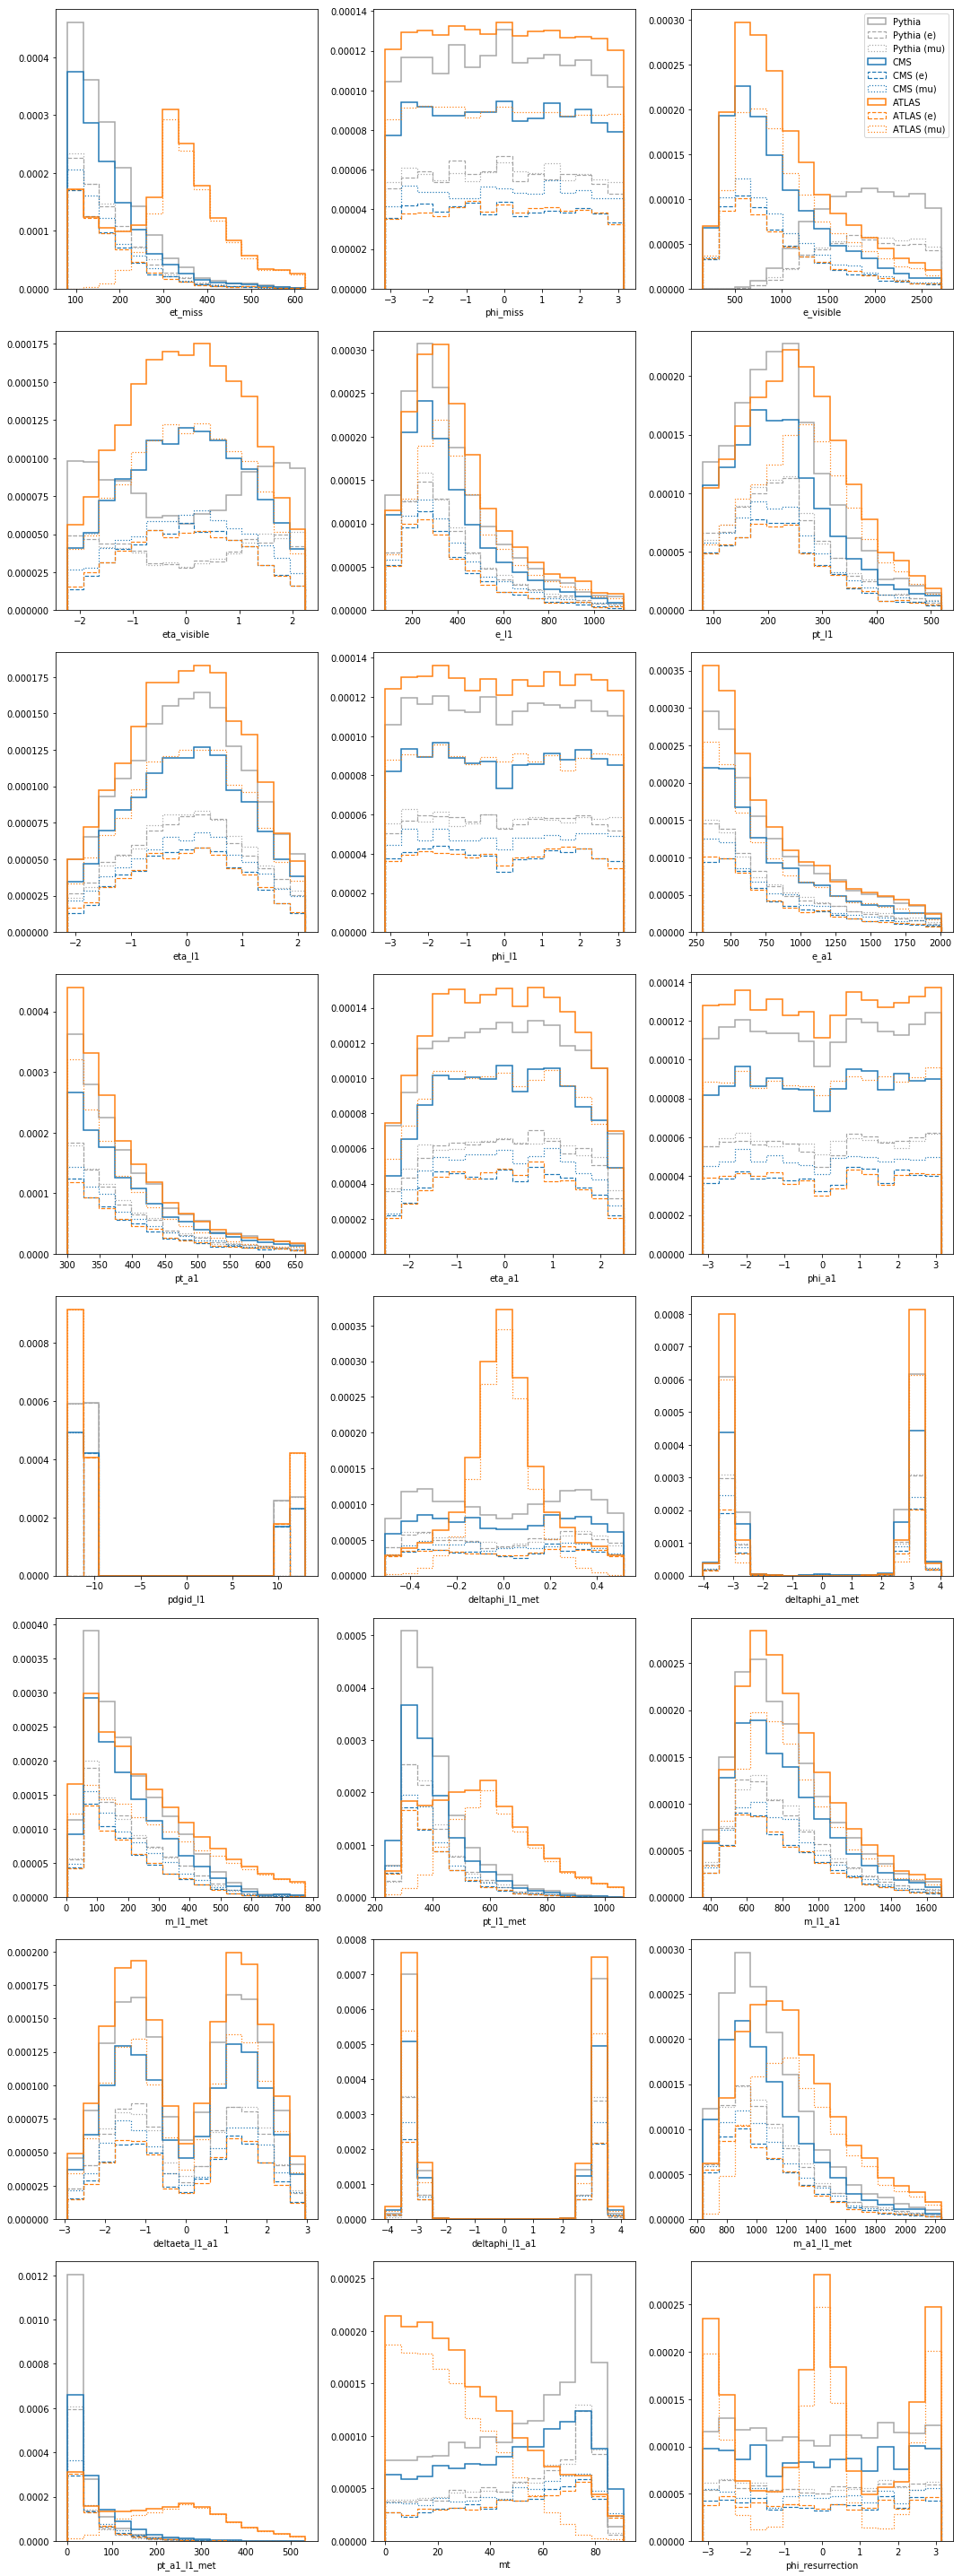

In [57]:
bins = 15
n_observables = x_pythia.shape[1]
n_cols = 3
n_rows = (n_observables + n_cols - 1) // n_cols
labels = sa.observables.keys()

plt.figure(figsize=(5. * n_cols, 5. * n_rows))

for i, label in enumerate(labels):
    xmin = np.percentile(x_atlas[:,i], 5.)
    xmax = np.percentile(x_atlas[:,i], 95.)
    xwidth = xmax - xmin
    xmin -= xwidth * 0.1
    xmax += xwidth * 0.1
    xmin = max(xmin, np.min(x_atlas[:,i]))
    xmax = min(xmax, np.max(x_atlas[:,i]))
    x_range = (xmin, xmax)
    
    ax = plt.subplot(n_rows, n_cols, i+1)
    
    
    electrons = (x_pythia[:,12]**2 < 12**2)
    muons = (x_pythia[:,12]**2 > 12**2)
    plt.hist(
        x_pythia[:,i], weights=weights_pythia,
        histtype='step', range=x_range, bins=bins,
        lw=1.5, color='0.65', ls='-',
        label=r'Pythia', density=False
    )
    plt.hist(
        x_pythia[electrons,i], weights=weights_pythia[electrons],
        histtype='step', range=x_range, bins=bins,
        lw=1.2, color='0.65', ls='--',
        label= 'Pythia (e)', density=False
    )
    plt.hist(
        x_pythia[muons,i], weights=weights_pythia[muons],
        histtype='step', range=x_range, bins=bins,
        lw=1.2, color='0.65', ls=':',
        label= 'Pythia (mu)', density=False
    )
    
    electrons = (x_cms[:,12]**2 < 12**2)
    muons = (x_cms[:,12]**2 > 12**2)
    plt.hist(
        x_cms[:,i], weights=weights_cms,
        histtype='step', range=x_range, bins=bins,
        lw=1.5, color='C0', ls='-',
        label=r'CMS', density=False
    )
    plt.hist(
        x_cms[electrons,i], weights=weights_cms[electrons],
        histtype='step', range=x_range, bins=bins,
        lw=1.2, color='C0', ls='--',
        label= 'CMS (e)', density=False
    )
    plt.hist(
        x_cms[muons,i], weights=weights_cms[muons],
        histtype='step', range=x_range, bins=bins,
        lw=1.2, color='C0', ls=':',
        label= 'CMS (mu)', density=False
    )
    
    
    electrons = (x_atlas[:,12]**2 < 12**2)
    muons = (x_atlas[:,12]**2 > 12**2)
    plt.hist(
        x_atlas[:,i], weights=weights_atlas,
        histtype='step', range=x_range, bins=bins,
        lw=1.5, color='C1', ls='-',
        label=r'ATLAS', density=False
    )
    plt.hist(
        x_atlas[electrons,i], weights=weights_atlas[electrons],
        histtype='step', range=x_range, bins=bins,
        lw=1.2, color='C1', ls='--',
        label= 'ATLAS (e)', density=False
    )
    plt.hist(
        x_atlas[muons,i], weights=weights_atlas[muons],
        histtype='step', range=x_range, bins=bins,
        lw=1.2, color='C1', ls=':',
        label= 'ATLAS (mu)', density=False
    )
    
    if i == 2:
        plt.legend(ncol=1)
        
    plt.xlabel(label)
    
plt.tight_layout()
plt.savefig("observables_pythia_vs_delphes.pdf")